In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
whos

Interactive namespace is empty.


In [3]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            187          14         169           2           3         169
Swap:            11          11           0


In [4]:
import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", (info.total/1024/1024/1024))
print("Free memory:", (info.free/1024/1024/1024))
print("Used memory:", (info.used/1024/1024/1024))

nvidia_smi.nvmlShutdown()

Total memory: 15.78173828125
Free memory: 15.7783203125
Used memory: 0.00341796875


In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True) 

In [6]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
#data_dir = '../Assets/fc_mats/'
data_dir = '../Assets/fc_mats_32smooth/'

In [7]:
files = [file for file in os.listdir(data_dir) if file.endswith('.npz')]
files.sort()

In [8]:
# Check if subject has .nii file
has_file = np.array([os.path.exists(os.path.join(data_dir,sub + '.npz')) for sub in df['bids_folder'].values])
print(has_file.mean())
assert has_file.mean()==1.0, 'fuck'

1.0


In [9]:
%time
# LOAD DATA
n_subs = len(df)
#n_subs = 200
data_size = np.hstack((n_subs,np.load(os.path.join(data_dir,df['bids_folder'].values[0] + '.npz'))['data'].shape))
data = np.zeros(data_size)
#for s in tqdm(range(len(df))):
for s in range(n_subs):
    sub = df['bids_folder'].values[s]
    datum = np.load(os.path.join(data_dir,sub + '.npz'))['data']
    data[s,:,:,:,:] = datum

CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 4.53 µs


In [10]:
df = df.iloc[0:n_subs]

In [11]:
hasnans = np.array([np.isnan(data[s,:,:,:,:]).sum()!=0 for s in range(data.shape[0])])
df = df.iloc[~hasnans]
data = data[~hasnans,:,:,:,:]

In [12]:
data.shape

(1048, 32, 32, 32, 51)

In [13]:
# def norm(mat):
#     normed = (mat - mat.min()) / (mat.max()-mat.min())
#     return normed 

In [14]:
# %time
# data = np.array([norm(data[i,:,:,:,:]) for i in range(data.shape[0])])
# data[np.isnan(data)]=0

In [15]:
assert np.isnan(data).mean()==0.0, 'you f****d up'

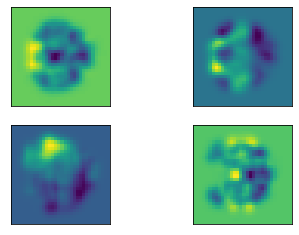

In [16]:
plt.subplot(2,2,1);plt.imshow(data[10,:,:,20,0]);plt.xticks([]);plt.yticks([]);
plt.subplot(2,2,2);plt.imshow(data[np.random.randint(0,data.shape[0]),:,:,20,0]);plt.xticks([]);plt.yticks([]);
plt.subplot(2,2,3);plt.imshow(data[np.random.randint(0,data.shape[0]),20,:,:,0]);plt.xticks([]);plt.yticks([]);
plt.subplot(2,2,4);plt.imshow(data[np.random.randint(0,data.shape[0]),:,20,:,0]);plt.xticks([]);plt.yticks([]);

In [17]:
%time
from helper_funcs import *
from importlib import reload
import make_models
reload(make_models)
del make_models
from make_models import *

from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


In [18]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [19]:
import make_models
reload(make_models)
from make_models import *
batch_size = 16
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(input_shape=tuple(data_size[1::]),
                   latent_dim = 8, 
                   batch_size = batch_size, 
                   disentangle = True, 
                   gamma = 1,
                   kernel_size = 3,
                   filters = 8,
                   intermediate_dim = 128,
                   nlayers = 2,
                   learning_rate=0.001)

In [20]:
patients = df['DX_GROUP'].values==1
controls = df['DX_GROUP'].values==2

#patient_data = data[patients,:,:,:,:]
#control_data = data[controls,:,:,:,:]

#patient_batch = patient_data[np.random.randint(low=0,high=patient_data.shape[0],size=32),:,:,:,:]
#control_batch = control_data[np.random.randint(low=0,high=control_data.shape[0],size=32),:,:,:,:]

In [21]:
loss = list()

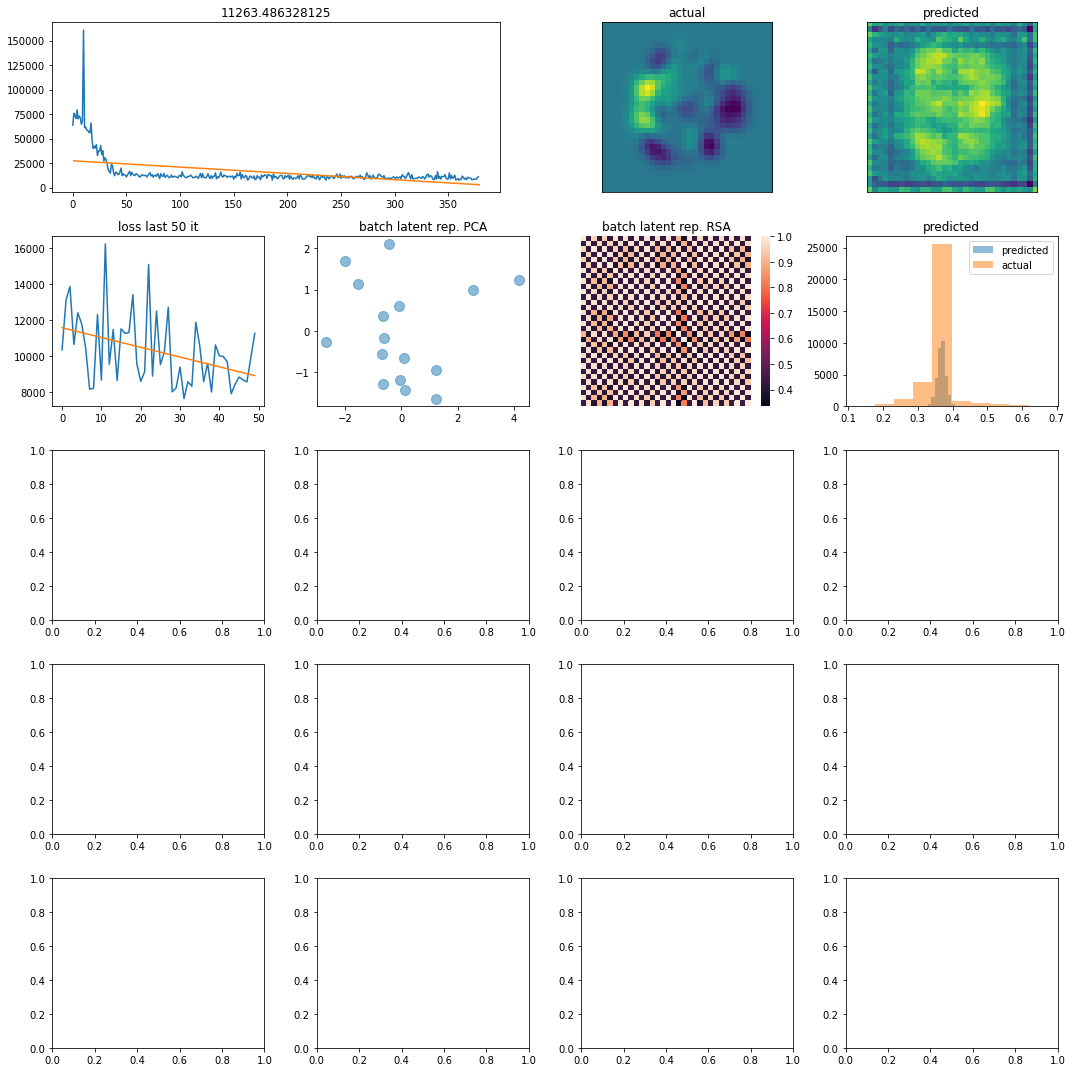

<ipython-input-22-8d83f8ddb32b>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1)
  4%|▍         | 380/10000 [42:32<17:56:46,  6.72s/it]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

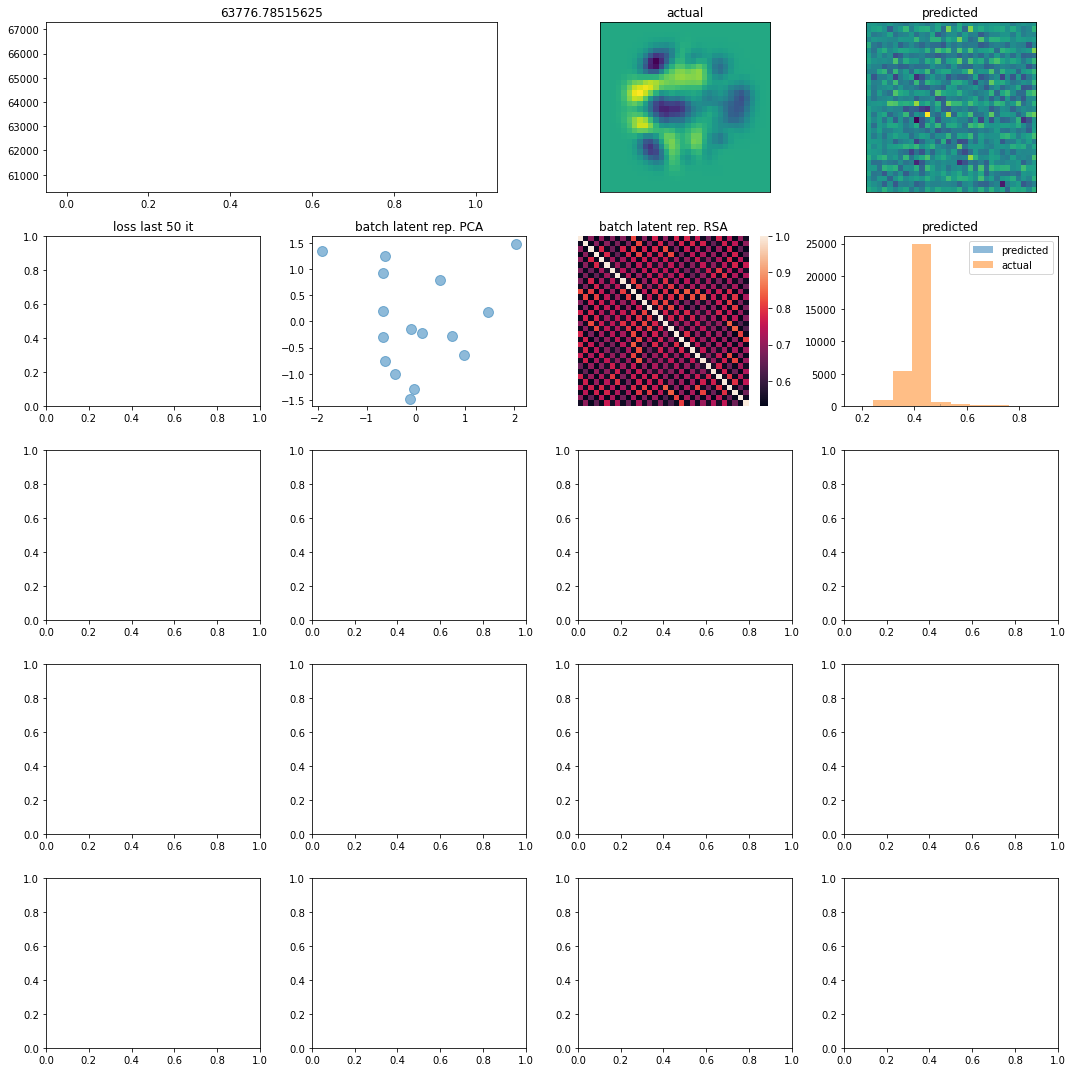

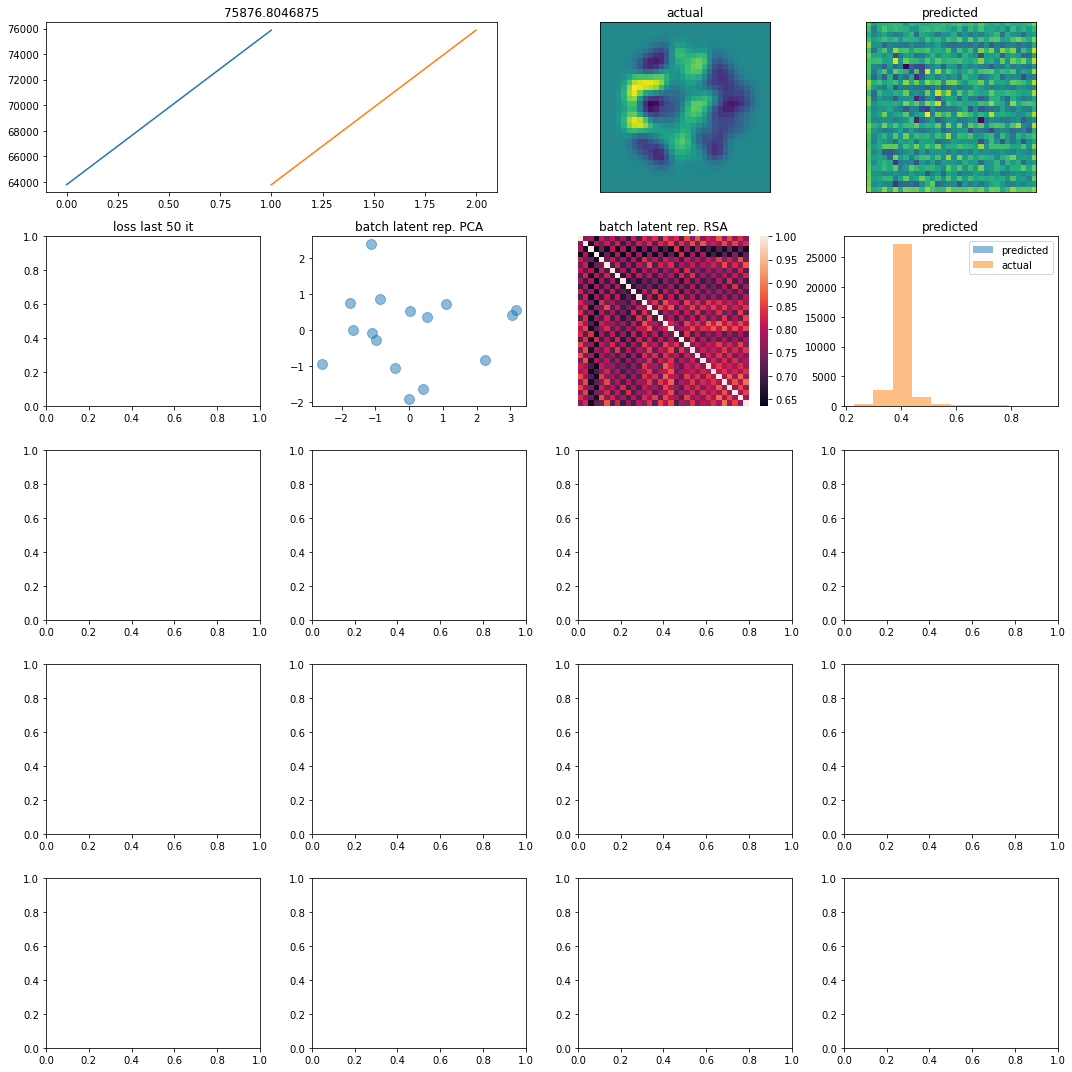

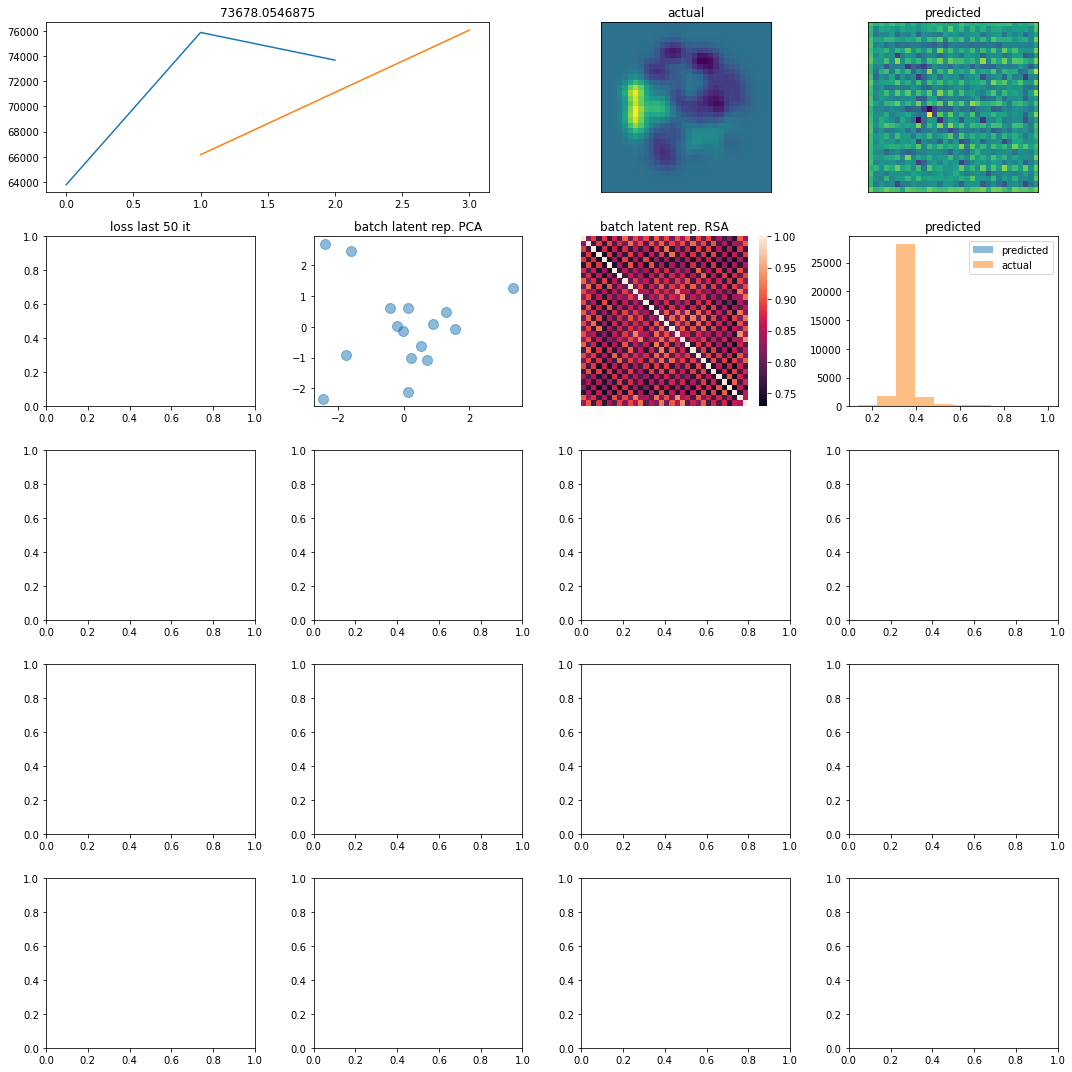

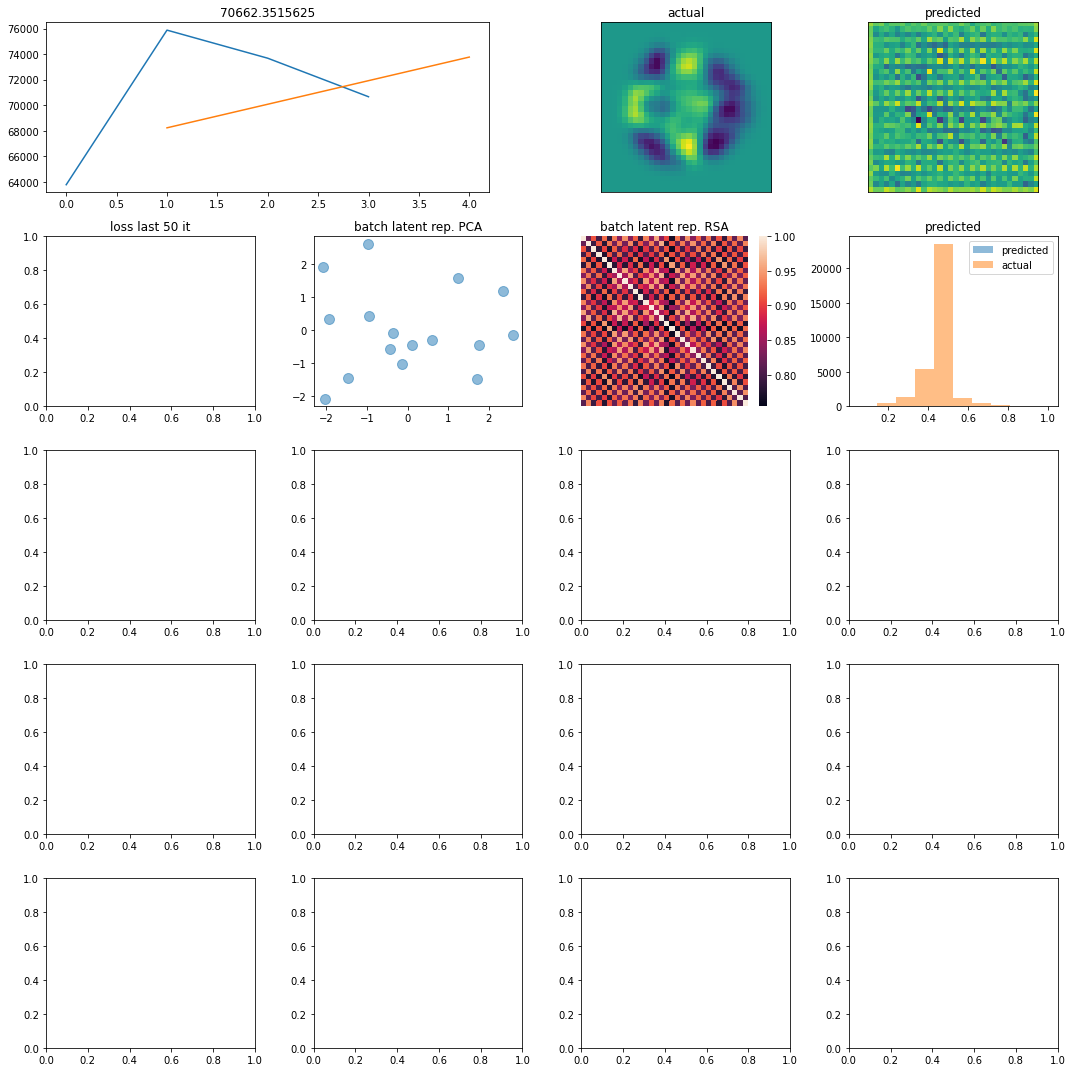

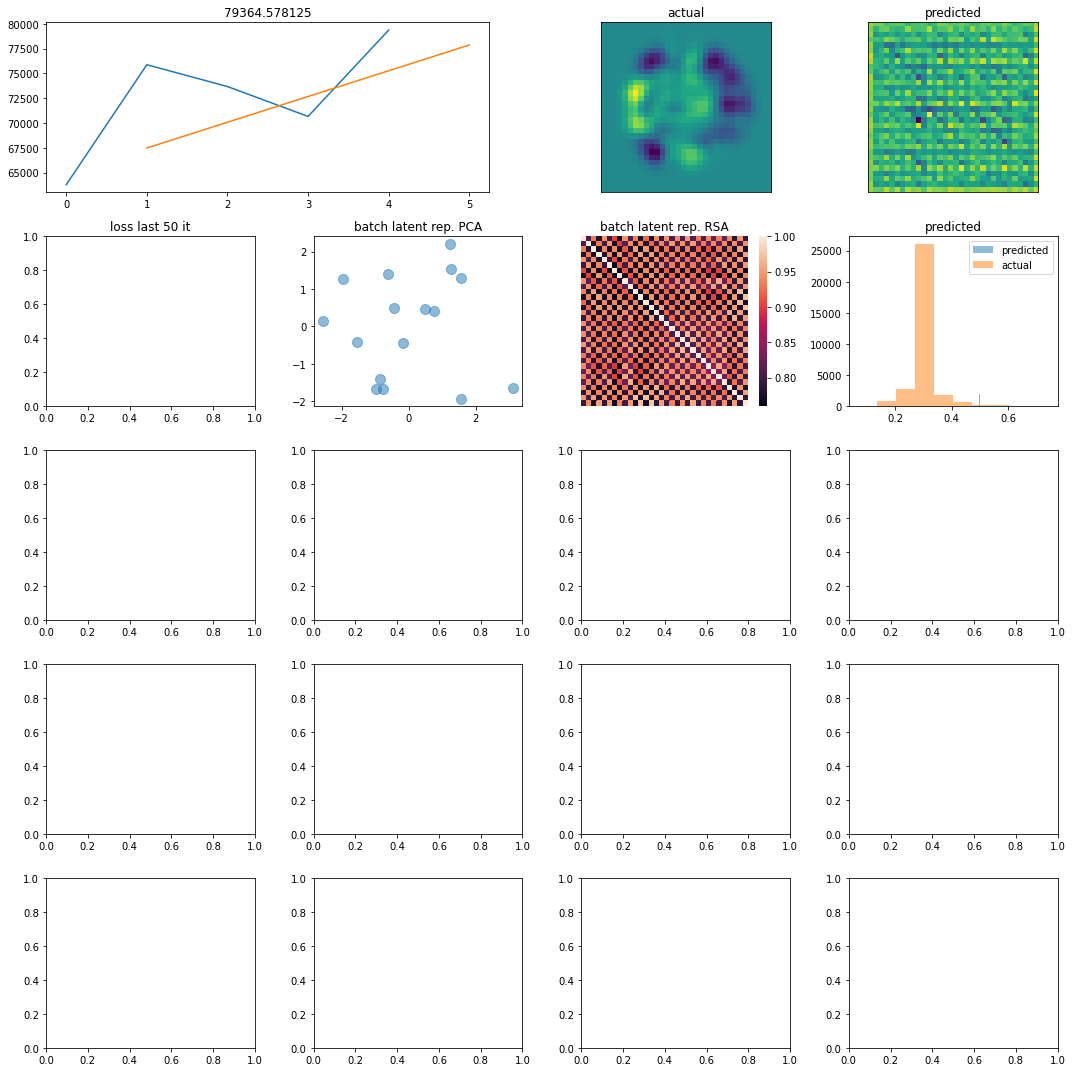

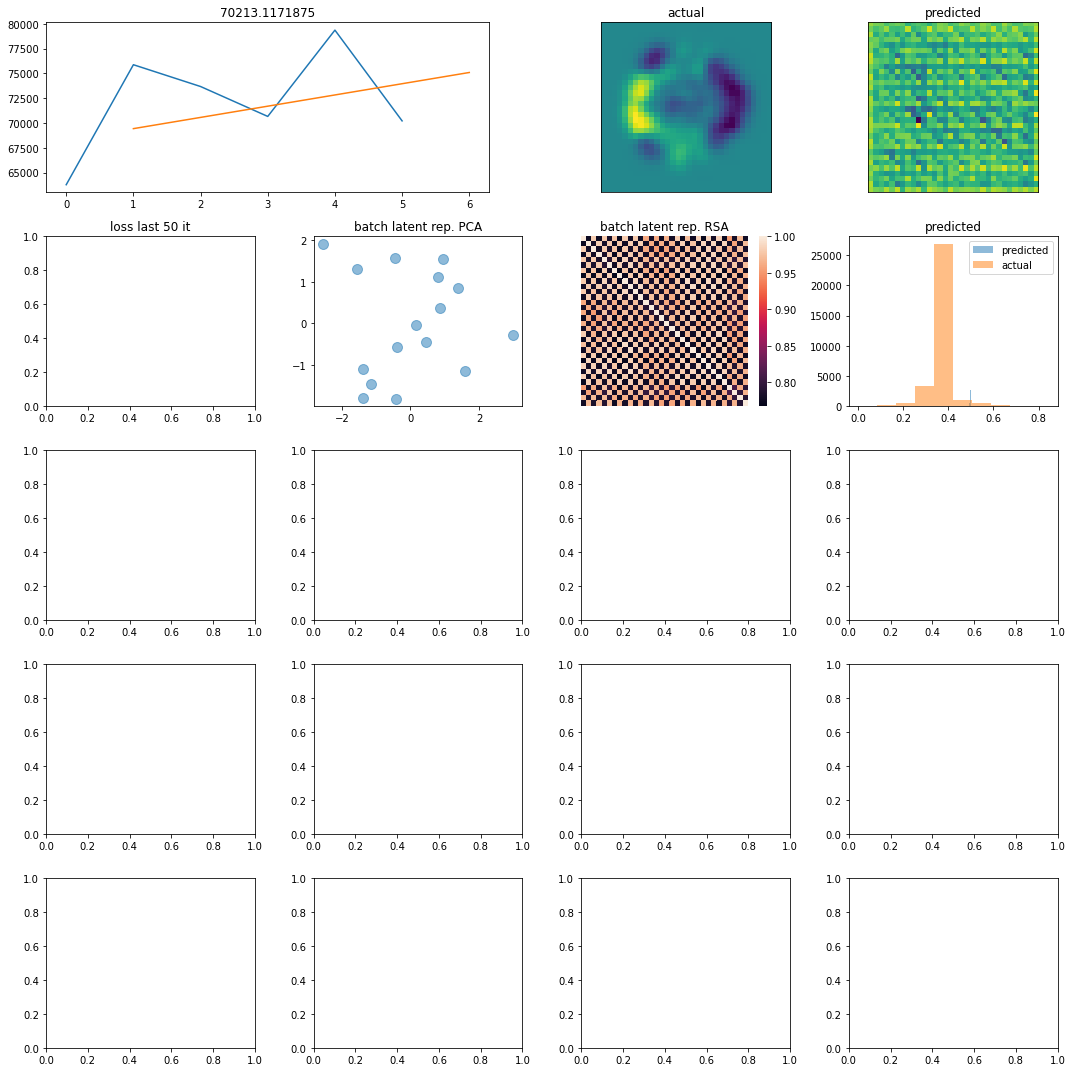

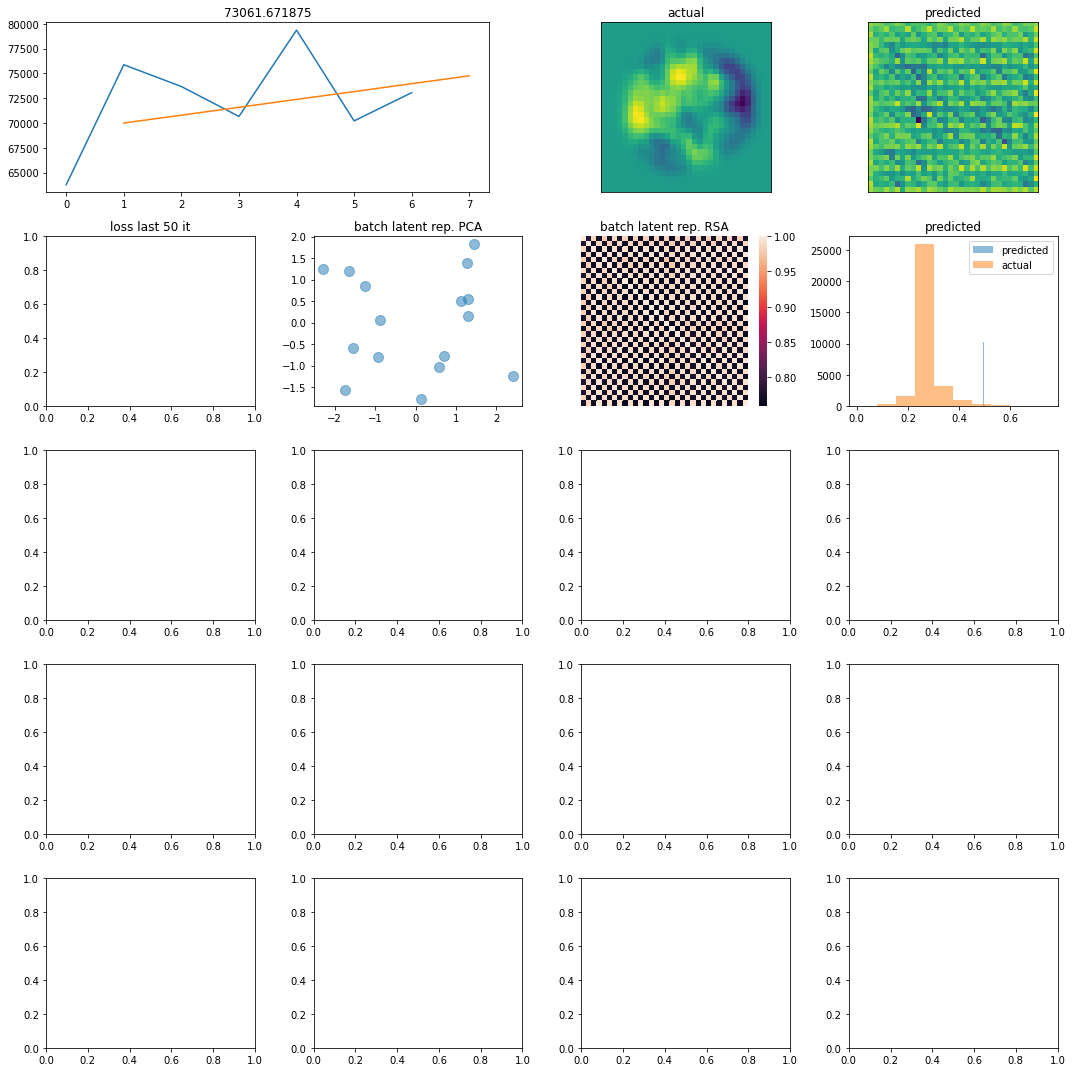

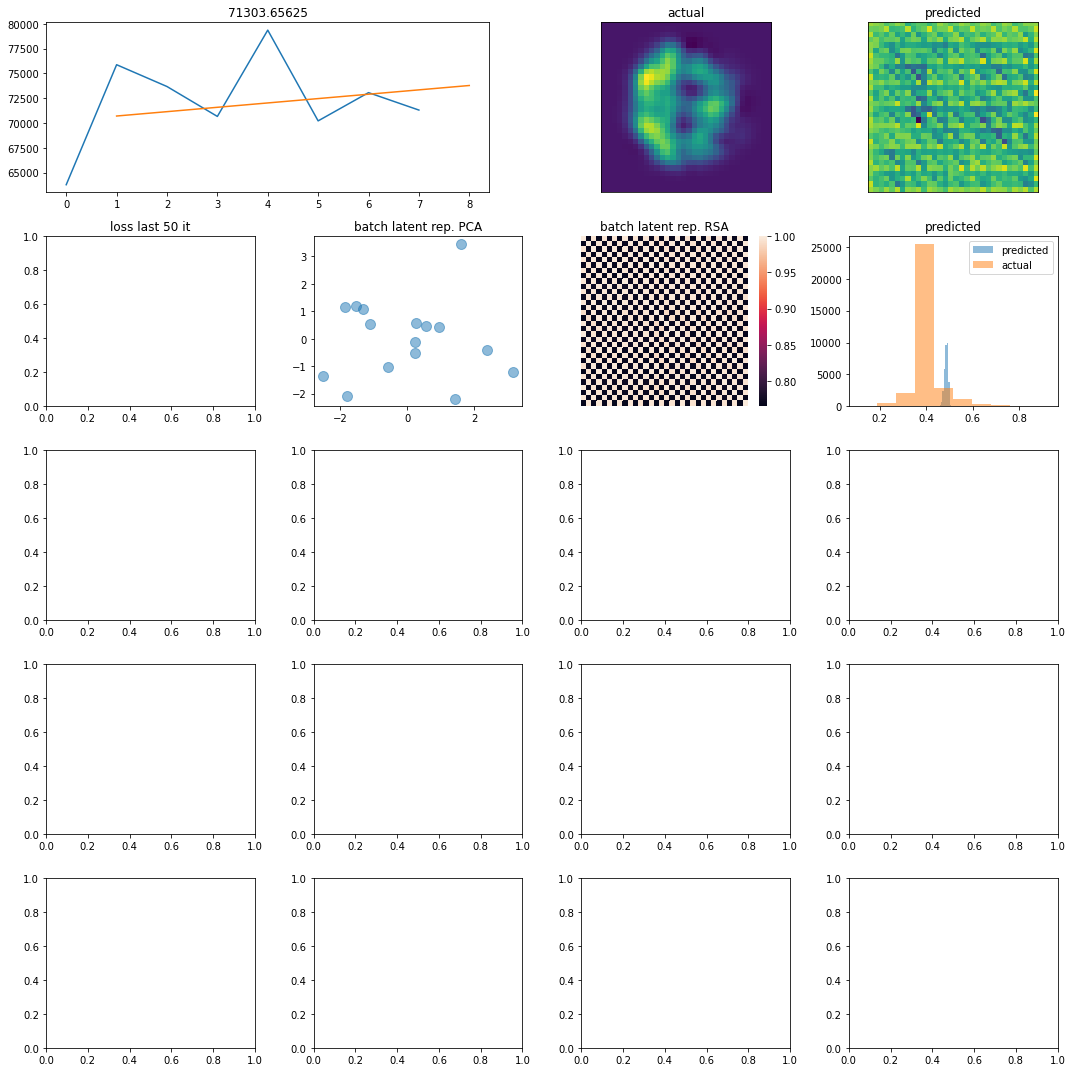

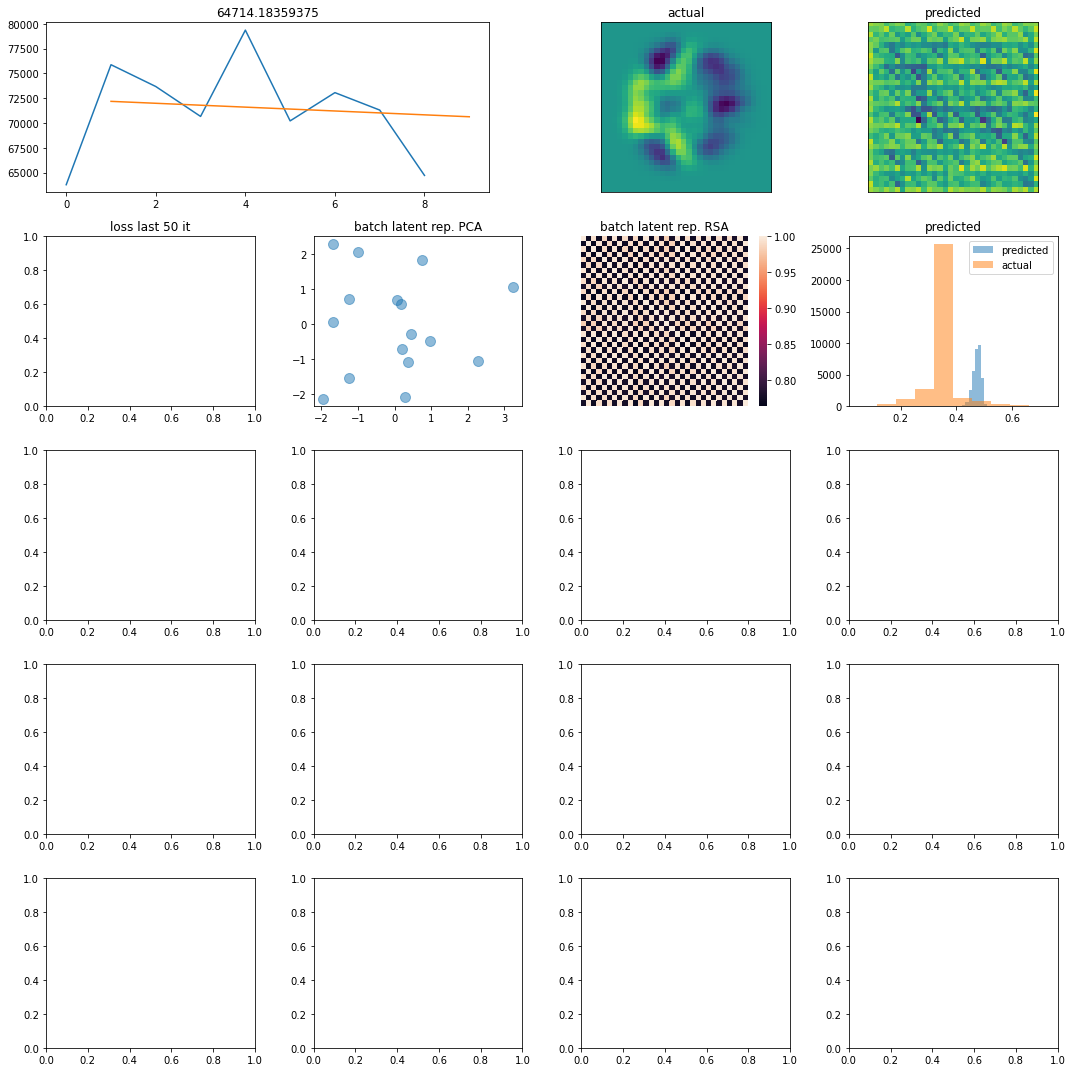

In [ ]:
for i in tqdm(range(10000),position=0, leave=True):
    
    patient_batch = data[patients,:,:,:,:][np.random.randint(low=0,high=patients.sum(),size=batch_size),:,:,:,:]
    control_batch = data[controls,:,:,:,:][np.random.randint(low=0,high=controls.sum(),size=batch_size),:,:,:,:]
    hist = cvae.train_on_batch([patient_batch,control_batch])
    assert not np.isnan(hist),'loss is NaN - you f**cked up'
    
    loss.append(hist)
    display.clear_output(wait=True);
    display.display(plt.gcf());
    
    #Organise figure
    ncols = 4;nrows=5
    plt.subplots(nrows,ncols,figsize=(15,15));
    
    # Plot loss
    plt.subplot(nrows,ncols/2,1)
    xs = np.arange(len(loss))+1
    m,b = np.polyfit(xs,loss,deg=1)
    plt.plot(loss)
    plt.plot(xs, m*xs + b)
    plt.title(hist)
    
    plt.subplot(nrows,ncols,5)
    hb = 50
    if len(loss)>hb:
        plot_loss = loss[-hb::]
        xs = np.arange(len(plot_loss))
        m,b = np.polyfit(xs,plot_loss,deg=1)
        plt.plot(plot_loss)
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
    plt.title(f'loss last {hb} it')
    
    # Plot recon
    #prediction = cvae.predict(patient_batch)    
    prediction = cvae.predict([patient_batch,control_batch])[0]
    
    plt.subplot(nrows,ncols,3)
    plt.imshow(patient_batch[0,:,:,20,0])
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    
    plt.subplot(nrows,ncols,4)
    plt.imshow(prediction[0,:,:,20,0])
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    
    plt.subplot(nrows,ncols,8)
    plt.hist(prediction[0,:,:,:,0].flatten(),alpha=.5)
    plt.hist(patient_batch[0,:,:,:,0].flatten(),alpha=.5)
    plt.legend(['predicted','actual']);plt.title('predicted')
    
    plt.subplot(nrows,ncols,6)
    pc = PCA(n_components=2).fit_transform(z_encoder.predict(patient_batch)[2])
    plt.scatter(pc[:,0],pc[:,1],s=100,alpha=.5);plt.title('batch latent rep. PCA')
    
    plt.subplot(nrows,ncols,7)
    sns.heatmap(np.corrcoef(prediction.reshape(32,-1)),xticklabels=[],yticklabels=[])
    plt.title('batch latent rep. RSA')
    
    plt.tight_layout()
    #sys.stdout.flush()